# Expected Value of Cost function in population setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

import helper.helper as h

## Generate $n$D Data

In [2]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), Sigma))
    
    return series

In [2]:
def generate_data_nD_2(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = series[t - 1] @ np.linalg.inv(P) @ A @ P + np.random.multivariate_normal(np.zeros(n), Sigma)
    
    return series

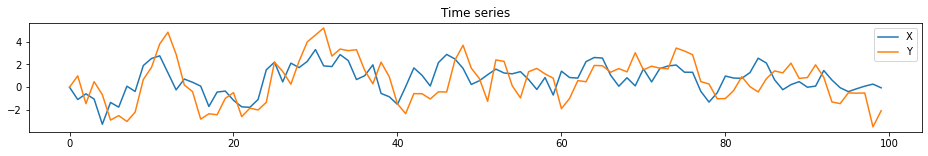

In [240]:
np.random.seed(seed = 123)

length, n = 100, 2
A, P, Sigma = None, None, None 

if n == 2:
    A = np.array([[0.8, 0.0], [0.5, 0.6]])
    P = np.array([[1.0, 0.0], [0.0, 1.0]])
    Sigma = np.identity(n)
elif n == 3:
    A = np.array([[0.5, 0.0, 0.0], [0.3, 0.4, 0.0], [0.2, 0.0, 0.6]])
    Sigma = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    
elif n == 4:
    
    P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])


U = A.T

# Generate nD data
series = generate_data_nD_2(length, n, U)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

Us, Ps = U.copy(), P.copy()

# Cost Function
$$C(A, P, A^*, P^*) = \left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2,$$
where we use the following value to predict $X_t$:
$$X_{t,pred} = P^{-1}APX_{t-1}$$
In reality, there is some underlying $P^*$, $A^*$ used to generate $X_{t,val}:$
$$X_{t, val} = P^{*-1}A^*P^*X_{t-1} + \Sigma.$$

This means that the cost function is 
$$C(A, P, A^*, P^*) = \left\lVert P^{*-1}A^*P^*X_{t-1} + \Sigma- P^{-1}APX_{t-1}\right\rVert_2^2,$$

## Distribution of $X$
We assume that $X_1 \sim \mathcal{N}\left(\mathbf{0}, \Sigma\right)$. Then, the distribution of $X_t$, where $t$ can be any integer, will be

$$X_t \sim \mathcal{N}\left(0, \Sigma_X\right),$$

where $$\text{vec}(\Sigma_X) = \left(I_{n^2} - B^* \otimes B^*\right)^{-1} \text{vec}(\Sigma),$$

and $$B^* = P^{*-1} A^* P^*.$$

More specifically, we have

$$\Sigma_X = \left(\text{vec}\left(I_n\right)^T \otimes I_m\right)\left(I_n \otimes \text{vec}(\Sigma_X) \right).$$

In [261]:
def expected_cost(U, P, Us = Us, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(U, P))
    Bs = np.matmul(Ps_inv, np.matmul(Us, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs.T, Bs.T)), Sigma.reshape(n ** 2)).reshape((n, n))
    
#     return covariance_X

    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

In [235]:
series = generate_data_nD_2(length * 500, n, U)
# print(np.cov(series.T))
# print(expected_cost(U, P, U, P))

We see that the analytic approach and the data sampling approach yield almost identical results, with the data sampling approach converging to the analytic approach when we take an infinite amount of samples.
## Expected cost when using $P^*$ and $A^*$
\begin{align*}\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] &= \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) \\
&= \text{Tr}\left(\Sigma + \left(B^* - B^*\right)\Sigma_X\left(B^* - B^*\right)^T\right) \\
&= \text{Tr}\left(\Sigma\right).
\end{align*}
Hence, we see that we achieve the minimum for $P^*$ and $A^*$.

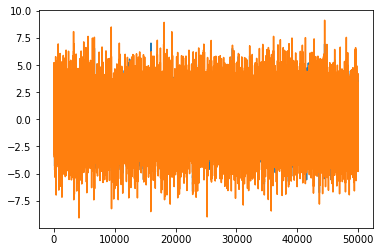

In [236]:
plt.plot(series)

In [268]:
def C_n(U = Us, P = Ps):
    """
    Given that series has been generated according to P*, A*,
    This function returns the cost when using estimates P, A.
    """
    
    cost = 0

    P_inv = np.linalg.inv(P)

    for t in range(1, length):
        val = series[t]
        est = series[t - 1] @ P_inv @ U @ P
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1)

print("Expected Cost when using P* and A*:", np.trace(Sigma))
print("Expected Cost when using P* and A*:", expected_cost(Us, Ps))

P_any = np.random.rand(n, n)
print("Cost from data when using P* and A*:", round(C_n(), 3))
print("Cost from data when using P* and A*:", round(C_n(P = P_any), 3))

Expected Cost when using P* and A*: 2.0
Expected Cost when using P* and A*: 2.0
Cost from data when using P* and A*: 2.236
Cost from data when using P* and A*: 5950.664


In [245]:
print(np.linalg.inv(P) @ U @ P)
print(np.linalg.inv(P_any) @ U @ P_any)

[[0.8 0.5]
 [0.  0.6]]
[[ 0.80789942  0.69075207]
 [-0.00237753  0.59210058]]


In [246]:
P_rand = np.identity(n)
U_rand = np.random.rand(n, n)
print(f"Expected cost using P = I and random U:\n{expected_cost(U_rand, P_rand)}.")
# print(np.mean(series[1:] - series[:-1] @ U_rand, axis = 0))
print(sum(np.mean((series[1:] - series[:-1] @ U_rand) ** 2, axis = 0)))
print(1 / (length * 500 - 1) * np.linalg.norm(series[1:] - series[:-1] @ U_rand, 'f') ** 2)
print(h.MSE(U_rand, series))
print(C_n(U_rand, P_rand))

# print(np.trace(np.cov(series.T)))

Expected cost using P = I and random U:
2.128098197020946.
2.6212338498734136
0.005190146825685872
2.621233849873413
2.6212338498734122


# Distribution of $\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]$
To derive the expectation of the cost, we first rewrite to
\begin{align*}
    \mathbb{E}\left[\left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2\right] &= \mathbb{E}\left[\sum_{i=1}^n \left(X_{t,val,i} - X_{t,pred,i} \right)^2\right]\\
    &= \text{Tr}\left(\mathbb{V}\left(X_{t,val} - X_{t, pred})\right)\right) \\
\end{align*}
coSo, we see that we need to determine the covariance of $X_{t,val} - X_{t,pred}$, or rather its trace. We derive the variance as follows:

\begin{align*}
\mathbb{V}\left(X_{t,val} - X_{t, pred})\right) &= \mathbb{V}\left(P^{*-1}A^*P^* X_{t-1} + \Sigma - P^{-1}APX_{t-1})\right)\\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t-1}\right)&\tag{Due to independence of $\Sigma$} \\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t}\right)&\tag{$X_t$, $X_{t-1}$ have same distribution} \\
&= \Sigma + \left(B^* - B\right)\mathbb{V}\left(X_{t}\right)\left(B^* - B\right)^T &\tag{Constant out of covariance}\\
&= \Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T, \tag{Fill in $\Sigma_X$}\\
\end{align*}
where $$B^* = P^{*-1} A^* P^*,\qquad B = P^{-1} A P.$$
Hence, 
$$\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] = \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right).$$

Furthermore, we see that the expected cost is a function of our data-generating $P^*$, $A^*$, and of our estimates $P$, $A$.

### Derivative of the population cost setting w.r.t. $A$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial A_{ij}} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A_{ij}} \tag{Fill in derived expected cost}\\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A_{ij}} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A_{ij}} \tag{Separate sum of derivatives} \\ &= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A_{ij}} + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial A_{ij}}\right) \tag{Interchange trace and derivative} \\ &= 0 + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial A_{ij}}\right) \tag{Derivative of $\Sigma$ is 0}\\ &= 2 \text{Tr}\left(\Sigma_X(B^* - B)^T \frac{\partial B^* - B}{\partial A_{ij}}\right) \tag{Use chain rule}\\ &= -2 \text{Tr}\left(\Sigma_X(B^* - B)^T P^{-1} J^{ij} P\right) \tag{Work out last derivative}
,\end{align*} where $$J^{ij}_{kl} = \begin{cases} 1 & k = i, l = j \\ 0 & \text{otherwise.}\end{cases}$$

In [247]:
def B_grad_u(U, P, i, j, Us = Us, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(U, P))
    Bs = np.matmul(Ps_inv, np.matmul(Us, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs.T, Bs.T)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

In [248]:
def B_grad_u_2(U, P, Us = Us, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(U, P))
    Bs = np.matmul(Ps_inv, np.matmul(Us, Ps))

    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs.T, Bs.T)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    return -2 * (Bs - B) @ covariance_X

In [249]:
U_2 = np.random.rand(n, n)

for i in range(n):
    for j in range(n):
        print(B_grad_u(U_2, P, i, j))

print(B_grad_u_2(U_2, P))

0.22964281775620543
-0.7746200391886143
5.288230275181963
5.2637786367348
[[ 0.22964282 -0.77462004]
 [ 5.28823028  5.26377864]]


### Derivative of the population cost setting w.r.t. $P$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial P_{ij}} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P_{ij}} \tag{Fill in derived expected cost}\\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P_{ij}} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P_{ij}} \tag{Separate sum of derivatives} \\ &= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P_{ij}} + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial P_{ij}}\right) \tag{Interchange trace and derivative} \\ &= 0 + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial P_{ij}}\right) \tag{Derivative of $\Sigma$ is 0}\\ &= 2\text{Tr}\left(\Sigma_X(B^* - B)^T \frac{\partial B^* - B}{\partial P_{ij}}\right) \tag{Use chain rule}\\ &= -2 \text{Tr}\left(\Sigma_X(B^* - B)^T \left(- P^{-1} J^{ij} P^{-1} AP + P^{-1}AJ^{ij}\right)\right) \tag{Work out last derivative}
,\end{align*} where $$J^{ij}_{kl} = \begin{cases} 1 & k = i, l = j \\ 0 & \text{otherwise.}\end{cases}$$

In [250]:
def B_grad_p(U, P, i, j, Us = Us, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(U, P))
    Bs = np.matmul(Ps_inv, np.matmul(Us, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs.T, Bs.T)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(U, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(U, P))))
    
    return -2 * np.trace(covariance_X @ (Bs - B).T @ B_grad)

In [230]:
def B_grad_p_2(U, P, i, j, Us = Us, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(U, P))
    Bs = np.matmul(Ps_inv, np.matmul(Us, Ps))
    
    print(P)
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs.T, Bs.T)), np.identity(n).reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(U, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(U, P))))
    
    # print((P_inv @ U).T)) - P_inv @ U)
    B_grad_all = P_inv @ U @ np.ones((n, n)) - P_inv @ np.ones((n, n)) @ P_inv @ U @ P
    # print(f"B_grad_all: {B_grad_all}.")
    print(-2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), B_grad_all[i][j]))))
    
    # der = 2 * (Bs - B) @ covariance_X @ ((P_inv @ U) - P_inv @ P_inv @ (U @ P).T)
    
    # print(f"B:grad:\n{np.trace(-2 * covariance_X @ (Bs - B).T @ B_grad)}.")
    # print(f"B:grad:\n{-2 * covariance_X * np.trace((Bs - B).T @ B_grad)}.")
    
#     print(der)
    
    # print(-2 * np.matmul(covariance_X, (Bs - B).transpose() * np.trace(B_grad)))
    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), B_grad)))

In [231]:
# U_2 = np.random.rand(n, n)
print(U_2)

for i in range(n):
    for j in range(n):
        print(B_grad_p(U_2, P, i, j))

i, j = 2, 2
print()
print(B_grad_p_2(U_2, P, i, j))

[[0.42994958 0.60102119 0.33808362]
 [0.20280958 0.94394743 0.49164859]
 [0.14893879 0.77980173 0.54795556]]
-0.3867536412730035
-0.017032449621430412
-0.31805097550430517
-0.6237082001522086
1.1032442804144855
-0.3271772554980794
-0.8146308741490974
0.05633489891747841
-0.716490639141482

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

## Verifications

### Gradient of A for $A = A^*$, $P = P^*$

1 1, ...,  1 2, ...,  2 2, ...,  

<ipython-input-365-485f2d34e5db>:58: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


[[0.8 0.5]
 [0.  0.6]]


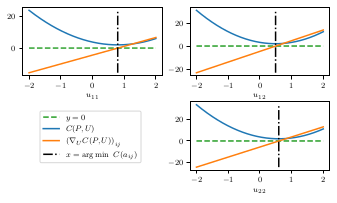

In [365]:
def verify_gradient_u(i, j, P = P, U = U):
    print(f"{i} {j}, ..., ", end = " ")
    u_list = np.linspace(-2, 2, 400)
    results = [[], []]
    
    u_temp = U[i - 1][j - 1]
    
    for u in u_list:
        U[i - 1][j - 1] = u
        results[0].append(expected_cost(U, P, Us, Ps))
        results[1].append(B_grad_u_2(U, P)[i-1][j-1])
        
    U[i - 1][j - 1] = u_temp

    plt.xlabel(f"$u_{{{i}{j}}}$")
    
#     print(f"Setting A[{i}][{j}] to optimum {-2 + 4 * np.argmin(results[0]) / 400}")
#     A[i - 1][j - 1] = -2 + 4 * np.argmin(results[0]) / 400
    
    # plt.ylim(-0.1,0.1)
    if i == 1 and j == 1:
        plt.plot([-2, 2], [0, 0], linestyle = '--', label = r"$y = 0$", color = 'C2')
        plt.plot(u_list, results[0], label = r"$C(P, U)$")
        plt.plot(u_list, results[1], label = r"$\left(\nabla_U C(P, U)\right)_{ij}$")
        
        plt.vlines(u_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        # plt.vlines(U[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{u}_{ij}$")
        
    else:
        plt.plot([-2, 2], [0, 0], linestyle = '--', color = 'C2')
        plt.plot(u_list, results[0])
        plt.plot(u_list, results[1])
        
        plt.vlines(u_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        # plt.vlines(U[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')
        
        

# Create a Position index
plt.figure(figsize = (5.5, 3))
plt.subplots_adjust(hspace = 0.375)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
# A, P = As.copy(), Ps.copy()

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop   
    if k != 2:
        ax = fig.add_subplot(n, n, position[k])
        verify_gradient_u(k // n + 1, k % n + 1, P = P, U = U)

fig.legend(loc = 'lower left', ncol = 1, borderaxespad = 5.0)
plt.show()
plt.savefig("gradient_descent_u_plots.pgf", bbox_inches = 'tight')
print(U)

NameError: name 'verify_gradient_a' is not defined

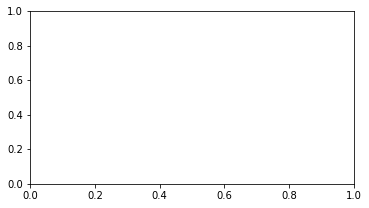

In [252]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = np.random.rand(n, n), np.identity(n)

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

print(As)

### Verify gradient of $P$ for $A = A^*$ and $P = P^*$

In [335]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

1 1, ...,  1 2, ...,  [0.002]
2 1, ...,  [0.002]
2 2, ...,  [0.998]


<ipython-input-350-77cf271da415>:61: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


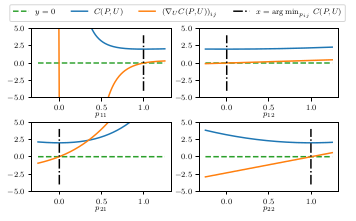

In [350]:
def verify_gradient_p(i, j, P = P, U = U):
    print(f"{i} {j}, ..., ", end = " ")
    p_list = np.linspace(-0.25, 1.25, 251)
    results = [[], []]
    
    p_temp = P[i - 1][j - 1]
    
    for p in p_list:
        P[i - 1][j - 1] = p
        results[0].append(expected_cost(U, P, Us, Ps))
        results[1].append(B_grad_p(U, P, i - 1, j - 1))
        
    P[i - 1][j - 1] = p_temp

    clip = True 
    
    for a in range(2):
        for b in range(251):
            if abs(results[a][b] ) > 8.000:
                results[a][b] = np.sign(results[a][b]) * 8.000
                clip = True
        
    plt.xlabel(f"$p_{{{i}{j}}}$", labelpad = 1.0)
    
    if clip: plt.ylim(-5.00,5.00)
    if i == 1 and j == 1:
        plt.plot([-0.25, 1.25], [0, 0], linestyle = '--', label = r"$y = 0$", color = 'C2')
        plt.plot(p_list, results[0], label = r"$C(P, U)$")
        plt.plot(p_list, results[1], label = r"$\left(\nabla_U C(P, U)\right)_{ij}$")
        
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], -4, 4, linestyle = 'dashdot', label = r"$x = {\arg \min}_{p_{ij}}\ C(P, U)$", color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot([-0.25, 1.25], [0, 0], linestyle = '--', color = 'C2')
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        
        print(p_list[np.where(results[0] == np.amin(results[0]))[0]])
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))[0]], -4, 4, linestyle = 'dashdot', color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

# Create a Position index
plt.figure(figsize = (5.5, 3))
plt.subplots_adjust(hspace = 0.35)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
U, P = Us.copy(), Ps.copy()

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_p(k // n + 1, k % n + 1, P = P, U = U)

fig.legend(loc = 'upper center', ncol = 4, borderaxespad = 0.6)
plt.savefig("gradient_descent_p_plots.pgf", bbox_inches = 'tight')
plt.show()

TypeError: verify_gradient_p() got an unexpected keyword argument 'A'

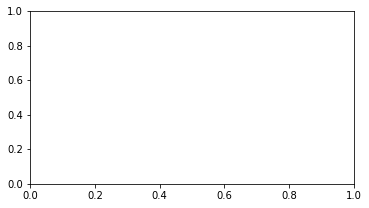

In [257]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As * 0.5 - 0.1, np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_p(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()